In [98]:
data = [
    [2.3976, 1.5328, 1.9044, 1.1937, 2.4184, 1.8649, 1],
    [2.3936, 1.4804, 1.9907, 1.2732, 2.2719, 1.8110, 1],
    [2.2880, 1.4585, 1.9867, 1.2451, 2.3389, 1.8099, 1],
    [2.2904, 1.4766, 1.8876, 1.2706, 2.2966, 1.7744, 1],
    [1.1201, 0.0587, 1.3154, 5.3783, 3.1849, 2.4276, 2],
    [0.9913, 0.1524, 1.2700, 5.3808, 3.0714, 2.3331, 2],
    [1.0915, 0.1881, 1.1387, 5.3703, 3.3561, 2.3833, 2],
    [1.0535, 0.1229, 1.2743, 5.3226, 3.0952, 2.3193, 2],
    [1.4871, 2.3448, 0.9918, 2.3160, 1.6783, 5.0850, 3],
    [1.3312, 2.2553, 0.9618, 2.4702, 1.7272, 5.0645, 3],
    [1.3646, 2.2945, 1.0562, 2.4763, 1.8051, 5.1470, 3],
    [1.4392, 2.2296, 1.1278, 2.4230, 1.7259, 5.0876, 3],
    [2.9364, 1.5323, 4.6109, 1.3160, 4.2000, 6.8749, 4],
    [2.9034, 1.4640, 4.6061, 1.4598, 4.2912, 6.9142, 4],
    [3.0181, 1.4918, 4.7051, 1.3521, 4.2623, 6.7966, 4],
    [2.9374, 1.4896, 4.7219, 1.3977, 4.1863, 6.8336, 4]
]


In [101]:
import numpy as np

data = np.array(data)

x = data[:, :-1]
y = data[:, -1]

In [99]:
train_x = x[::2]
train_x

array([1.0535, 1.2743, 3.0952])

In [198]:
import numpy as np
import matplotlib.pyplot as plt

class LVQ_1:
    def __init__(self, input_size, weight_size, hyper_params):
        self.input_size = input_size
        self.hyper_params = hyper_params

        # 將參考向量的設為 0
        self.weight = np.zeros((weight_size, input_size))
        self.labels = np.zeros(weight_size)

    def weight_init(self, weight, labels):
        # 將每個參考向量平均分配給每個 class
        unique_labels = np.unique(labels)
        n_label = self.weight.shape[0] // len(unique_labels)
        idx = 0
        for label in unique_labels:
            self.labels[idx:idx+n_label] = label
            idx += n_label  
        return weight
    
    def cal_input_weight_distance(self, x, weight):
        # 將所有 weight point 個別減去同個 x 後取歐式距離 (L2 norm)
        x_reshaped = x.reshape(1, -1)
        distances = np.linalg.norm(weight - x_reshaped, axis=1)
        return distances

    def find_winner(self, x):
        distances = self.cal_input_weight_distance(x, self.weight)
        # 找到距離當前 x 最近的 weight point 的 index
        return np.argmin(distances)

    def update_weight(self, x, y, winner_pos):
        if y == self.labels[winner_pos]:
            # 距離最近的參考向量的 class 與當前 sample 的 class 相同，將參考向量往靠近 sample 靠近
            self.weight[winner_pos] += self.hyper_params['lr'] * (x - self.weight[winner_pos])
        else:
            # 距離最近的參考向量的 class 與當前 sample 的 class 不同，將參考向量遠離 sample
            self.weight[winner_pos] -= self.hyper_params['lr'] * (x - self.weight[winner_pos])

    def train(self, samples, labels):
        self.weight = self.weight_init(self.weight, labels)
        
        err_arr = []
        for _ in range(self.hyper_params['epochs']):    
            for (x, y) in zip(samples, labels):
                winner_pos = self.find_winner(x)
                self.update_weight(x, y, winner_pos)

            err_arr.append(self.cal_err(samples, labels))
        self.plot_convergence(err_arr)
    
    def cal_err(self, samples, labels):
        total_err = 0
        # 找出每個 weight point 的 class 所對應到的 class sample 的中心點，並計算平均距離 
        for i in range(len(self.weight)):
            class_samples = samples[labels == self.labels[i]]
            if len(class_samples) == 0:
                continue
            avg_dist = self.cal_input_weight_distance(np.mean(class_samples, axis=0), self.weight[i])     
            total_err += avg_dist
        return total_err

    def predict(self, x):
        winner_pos = self.find_winner(x)
        return self.labels[winner_pos]

    def plot_convergence(self, err_arr):
        plt.figure(figsize=(6, 5))
        plt.plot(err_arr, 'b-')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.grid(True)
        plt.show()

    
    
def visualize_features(data, feat_list, labels, model):
    fig_size = int(np.ceil(np.sqrt(len(feat_list))))
    cmap = plt.get_cmap('tab10')
    plt.figure(figsize=(9, 9))
    for idx, (f1, f2) in enumerate(feat_list):
        plt.subplot(fig_size, fig_size, idx+1)
        plt.grid()
        plt.xlabel(f'feature {f1}')
        plt.ylabel(f'feature {f2}')
        plt.scatter(data[:, f1], data[:, f2], s=40, marker='o', facecolors='none', edgecolors=[cmap(i) for i in labels.astype(int)])
        plt.scatter(model.weight[:, f1], model.weight[:, f1], s=40, marker='x', c=[cmap(i) for i in model.labels.astype(int)])
    plt.show()

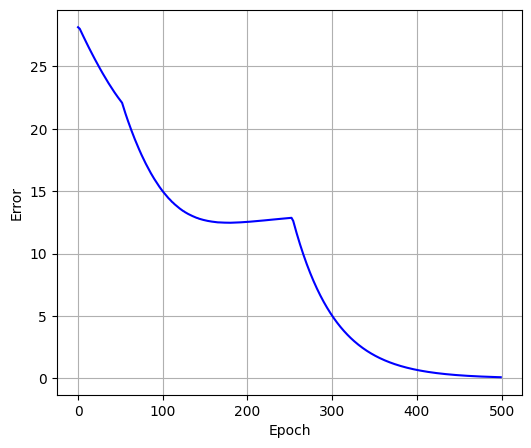

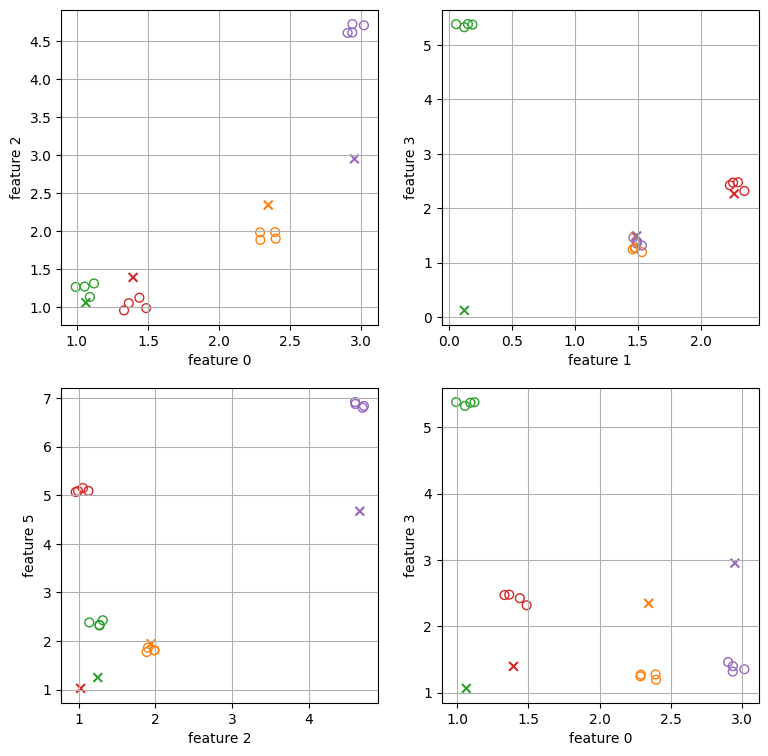

In [207]:
np.random.seed(0)
np.random.shuffle(data)

model = LVQ_1(input_size=6, weight_size=4, hyper_params={'epochs': 500, 'lr': 0.005})

model.train(data[:, :-1], data[:, -1])
visualize_features(data, [[0, 2], [1, 3], [2, 5], [0, 3]], data[:, -1], model)

In [136]:
model.total_err

array([14.77535052, 24.76249137, 31.35673196, 27.20712888])

In [208]:
for (x, y) in zip(data[:, :-1], data[:, -1]):
    pred = model.predict(x).astype(int)
    print(x, pred, int(y))
    


[2.9374 1.4896 4.7219 1.3977 4.1863 6.8336] 4 4
[1.4871 2.3448 0.9918 2.316  1.6783 5.085 ] 3 3
[2.3936 1.4804 1.9907 1.2732 2.2719 1.811 ] 1 1
[2.9034 1.464  4.6061 1.4598 4.2912 6.9142] 4 4
[2.2904 1.4766 1.8876 1.2706 2.2966 1.7744] 1 1
[1.3646 2.2945 1.0562 2.4763 1.8051 5.147 ] 3 3
[3.0181 1.4918 4.7051 1.3521 4.2623 6.7966] 4 4
[2.288  1.4585 1.9867 1.2451 2.3389 1.8099] 1 1
[1.0535 0.1229 1.2743 5.3226 3.0952 2.3193] 2 2
[2.3976 1.5328 1.9044 1.1937 2.4184 1.8649] 1 1
[2.9364 1.5323 4.6109 1.316  4.2    6.8749] 4 4
[1.4392 2.2296 1.1278 2.423  1.7259 5.0876] 3 3
[1.3312 2.2553 0.9618 2.4702 1.7272 5.0645] 3 3
[1.0915 0.1881 1.1387 5.3703 3.3561 2.3833] 2 2
[1.1201 0.0587 1.3154 5.3783 3.1849 2.4276] 2 2
[0.9913 0.1524 1.27   5.3808 3.0714 2.3331] 2 2


In [108]:
model.weight

array([[2.34265124, 1.48699555, 1.94284179, 1.24572569, 2.33125466,
        1.81511772],
       [1.06422627, 0.13023619, 1.24992212, 5.36322248, 3.17687855,
        2.36617048],
       [1.40543951, 2.28140607, 1.03417075, 2.4213836 , 1.73436364,
        5.09627569],
       [2.94897225, 1.49429983, 4.66154297, 1.38157137, 4.23485995,
        6.85452159]])

In [110]:
model.predict(data[4, :-1])

3.0

In [111]:
data

array([[1.0535, 0.1229, 1.2743, 5.3226, 3.0952, 2.3193, 2.    ],
       [2.2904, 1.4766, 1.8876, 1.2706, 2.2966, 1.7744, 1.    ],
       [1.4392, 2.2296, 1.1278, 2.423 , 1.7259, 5.0876, 3.    ],
       [2.9364, 1.5323, 4.6109, 1.316 , 4.2   , 6.8749, 4.    ],
       [1.3312, 2.2553, 0.9618, 2.4702, 1.7272, 5.0645, 3.    ],
       [1.0915, 0.1881, 1.1387, 5.3703, 3.3561, 2.3833, 2.    ],
       [2.9034, 1.464 , 4.6061, 1.4598, 4.2912, 6.9142, 4.    ],
       [3.0181, 1.4918, 4.7051, 1.3521, 4.2623, 6.7966, 4.    ],
       [2.3976, 1.5328, 1.9044, 1.1937, 2.4184, 1.8649, 1.    ],
       [1.4871, 2.3448, 0.9918, 2.316 , 1.6783, 5.085 , 3.    ],
       [2.288 , 1.4585, 1.9867, 1.2451, 2.3389, 1.8099, 1.    ],
       [1.3646, 2.2945, 1.0562, 2.4763, 1.8051, 5.147 , 3.    ],
       [2.3936, 1.4804, 1.9907, 1.2732, 2.2719, 1.811 , 1.    ],
       [0.9913, 0.1524, 1.27  , 5.3808, 3.0714, 2.3331, 2.    ],
       [2.9374, 1.4896, 4.7219, 1.3977, 4.1863, 6.8336, 4.    ],
       [1.1201, 0.0587, 1